## Depth estimation

Dataset: http://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html.  

### Description of the different objects

```
accelData – Nx4 matrix of accelerometer values indicated when each frame was taken. The columns contain the roll, yaw, pitch and tilt angle of the device.
depths – HxWxN matrix of in-painted depth maps where H and W are the height and width, respectively and N is the number of images. The values of the depth elements are in meters.
images – HxWx3xN matrix of RGB images where H and W are the height and width, respectively, and N is the number of images.
instances – HxWxN matrix of instance maps. Use get_instance_masks.m in the Toolbox to recover masks for each object instance in a scene.
labels – HxWxN matrix of object label masks where H and W are the height and width, respectively and N is the number of images. The labels range from 1..C where C is the total number of classes. If a pixel’s label value is 0, then that pixel is ‘unlabeled’.
names – Cx1 cell array of the english names of each class.
namesToIds – map from english label names to class IDs (with C key-value pairs)
rawDepths – HxWxN matrix of raw depth maps where H and W are the height and width, respectively, and N is the number of images. These depth maps capture the depth images after they have been projected onto the RGB image plane but before the missing depth values have been filled in. Additionally, the depth non-linearity from the Kinect device has been removed and the values of each depth image are in meters.
rawDepthFilenames – Nx1 cell array of the filenames (in the Raw dataset) that were used for each of the depth images in the labeled dataset.
rawRgbFilenames – Nx1 cell array of the filenames (in the Raw dataset) that were used for each of the RGB images in the labeled dataset.
scenes – Nx1 cell array of the name of the scene from which each image was taken.
sceneTypes – Nx1 cell array of the scene type from which each image was taken.
```

In [1]:
# download data
# !wget http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat -q

In [2]:
!sudo pip install bcolz -q

In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import bcolz
%matplotlib inline

In [4]:
img_mu = np.array([125,107,102])
img_std = 76.4
depth_mu = 2.7
depth_std = 1.4

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def prepare_raw_dataset():
    raw = h5py.File('nyu_depth_v2_labeled.mat')
    N,channels,width,height = raw['images'].shape
    images = bcolz.fill( (N,height,width,channels),dtype='float32',rootdir="data/images_bcolz",mode="w")
    depths = bcolz.fill( (N,height,width,1),dtype='float32',rootdir="data/depths_bcolz",mode="w")

    size = 100

    print('transform images..')
    for i, img in enumerate(chunks(raw['images'] ,size)):
        img = np.einsum('nkli->nilk', img)
        img = ((img-img_mu)/img_std)
        images[(i*size):min((i+1)*size,N),] = img

    images.flush()
    print('transform depths..')
    for i, depth in enumerate(chunks(raw['depths'] ,size)):
        depth = np.einsum('nkl->nlk', depth)
        depth = (depth-depth_mu)/1.5
        depth = np.expand_dims(depth,-1)
        depths[(i*size):min((i+1)*size,N),] = depth
    depths.flush()
    
    return images, depths

In [5]:
preprocess = False

if preprocess:
    images, depths = prepare_raw_dataset()
else:
    images = bcolz.open("data/images_bcolz/")
    depths = bcolz.open("data/depths_bcolz/")
    
N,height,width,channels = images.shape

In [6]:
np.random.seed(5)
allIdx = np.random.permutation(N)

Ntrain = int(N*0.7)
trainIdx = allIdx[:Ntrain]
testIdx = allIdx[Ntrain:]

In [7]:
def prepare_batch(index,bs = 10):
    while True:
        sample_idx = np.random.choice(index,bs,replace=False)
        img = images[sample_idx,]
        depth = depths[sample_idx,]
        depth = np.expand_dims(depth,-1)
        yield img, depth

In [8]:
def plot_image_and_depth(img,depth, alpha = 0.4):
    img = np.squeeze(img)
    plt.imshow(img*img_std + img_mu)
    plt.imshow(np.squeeze(depth)*depth_std + depth_mu,alpha=alpha)

In [9]:
x,y = prepare_batch(trainIdx,10).next()

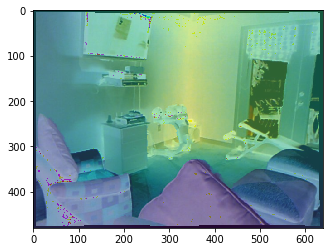

In [10]:
i = 3
plot_image_and_depth(x[i,],y[i,],alpha=0.5)

## Model

In [11]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [12]:
input_img = Input(shape=(height,width,channels))

In [13]:
def downsample(x,filters):
    conv = Conv2D(filters,3, activation='relu', padding='same', name='down_%d_%d' %(filters,1))(x)
    conv = Conv2D(filters,3, activation='relu', padding='same', name='down_%d_%d' %(filters,2))(conv)
    x = AveragePooling2D()(conv)
    return x, conv

In [14]:
x, conv1 = downsample(input_img,32)
x, conv2 = downsample(x,64)
x, conv3 = downsample(x,128)
x, conv4 = downsample(x,256)
_, conv5 = downsample(x,512)


In [15]:
for conv in [conv1,conv2,conv3,conv4,conv5]:
    print conv

Tensor("down_32_2/Relu:0", shape=(?, 480, 640, 32), dtype=float32)
Tensor("down_64_2/Relu:0", shape=(?, 240, 320, 64), dtype=float32)
Tensor("down_128_2/Relu:0", shape=(?, 120, 160, 128), dtype=float32)
Tensor("down_256_2/Relu:0", shape=(?, 60, 80, 256), dtype=float32)
Tensor("down_512_2/Relu:0", shape=(?, 30, 40, 512), dtype=float32)


In [16]:
def upsample(x,downConv,filters):
    up = UpSampling2D(size=(2, 2))(x)
    up = concatenate([up,downConv])
    up = Conv2D(filters,3, activation='relu', padding='same',name='up_%d_%d' %(filters,1))(up)
    up = Conv2D(filters,3, activation='relu', padding='same',name='up_%d_%d' %(filters,2))(up)
    return up

In [17]:
up4 = upsample(conv5,conv4,256)
up3 = upsample(up4,conv3,128)
up2 = upsample(up3,conv2,32)
up1 = upsample(up2,conv1,30)

In [18]:
up1

<tf.Tensor 'up_30_2/Relu:0' shape=(?, 480, 640, 30) dtype=float32>

In [19]:
deephat = Conv2D(1, (1, 1))(up1)
deephat

<tf.Tensor 'conv2d_1/BiasAdd:0' shape=(?, 480, 640, 1) dtype=float32>

In [20]:
model = Model(input_img,deephat)
model.compile(optimizer=Adam(lr=0.0001),loss="mse")

In [21]:
#model.summary()

In [22]:
# UNET (OVERWRITES WHATEVER WAS ABOVE)
#from UNet import UNet
#from keras.optimizers import Adam
#model = UNet().create_model((height,width,channels),1)
#model.compile(optimizer=Adam(lr=0.0001),loss="mse")
#model.summary()

In [23]:
callbacks = [ReduceLROnPlateau(patience=2,verbose=1),
            EarlyStopping(monitor="loss",patience = 5, verbose=1),
            ModelCheckpoint("models/best_model.hdf5",verbose=0,save_best_only=True)]

In [24]:
bs = 10
steps_per_epoch=int(Ntrain/bs)
print("Starting with a batch size of %d and %d steps per epoch." % (bs,steps_per_epoch))
model.fit_generator(prepare_batch(trainIdx,bs),
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    validation_data = prepare_batch(testIdx,bs),
                    validation_steps=steps_per_epoch/3,
                    callbacks=callbacks,
                   verbose=2)

# baseline mse (=0) is 0.85

Starting with a batch size of 10 and 101 steps per epoch.
Epoch 1/100
75s - loss: 0.7960 - val_loss: 0.9041
Epoch 2/100
71s - loss: 0.8001 - val_loss: 0.7156
Epoch 3/100
71s - loss: 0.7604 - val_loss: 0.7864
Epoch 4/100
71s - loss: 0.7277 - val_loss: 0.7893
Epoch 5/100

Epoch 00004: reducing learning rate to 9.99999974738e-06.
71s - loss: 0.7280 - val_loss: 0.7386
Epoch 6/100
71s - loss: 0.6870 - val_loss: 0.7878
Epoch 7/100
71s - loss: 0.6382 - val_loss: 0.6990
Epoch 8/100
71s - loss: 0.6946 - val_loss: 0.6818
Epoch 9/100
71s - loss: 0.7090 - val_loss: 0.6723
Epoch 10/100
71s - loss: 0.6603 - val_loss: 0.6892
Epoch 11/100
71s - loss: 0.6812 - val_loss: 0.6731
Epoch 12/100

Epoch 00011: reducing learning rate to 9.99999974738e-07.
71s - loss: 0.6332 - val_loss: 0.6836
Epoch 13/100
71s - loss: 0.6649 - val_loss: 0.6903
Epoch 14/100
71s - loss: 0.6938 - val_loss: 0.6691
Epoch 15/100
71s - loss: 0.6819 - val_loss: 0.6728
Epoch 16/100
71s - loss: 0.6776 - val_loss: 0.7290
Epoch 17/100

Epo

In [41]:
model.load_weights("models/best_model.hdf5")

In [43]:
x.shape

(10, 480, 640, 3)

In [53]:
x,y = prepare_batch(testIdx).next()
test_img = x[1:2,]
test_depth = y[1:2,]
dhat = model.predict(test_img)

In [54]:
np.min(depths[1:2])

-1.0508436

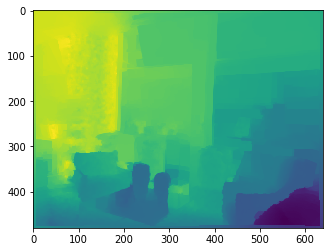

In [55]:
plt.imshow(np.squeeze(test_depth))

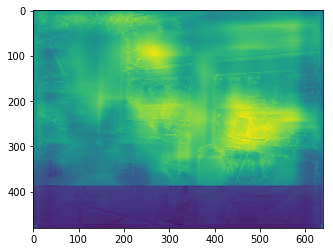

In [56]:
plt.imshow(np.squeeze(dhat))

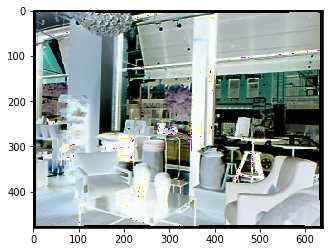

In [57]:
plot_image_and_depth(test_img,dhat,alpha=0)